Please refer to [the IBM Hello World Guide](https://docs.quantum.ibm.com/guides/hello-world)

In [1]:
# Print the version of Qiskit we're using
import qiskit

print(qiskit.version.VERSION)

1.4.1


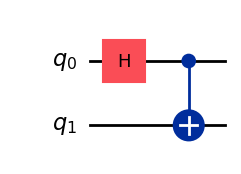

In [2]:
from qiskit import QuantumCircuit

# Create a new circuit with two qubits
qc = QuantumCircuit(2)
 
# Add a Hadamard gate to qubit 0
qc.h(0)
 
# Perform a controlled-X gate on qubit 1, controlled by qubit 0
qc.cx(0, 1)
 
# Return a drawing of the circuit using MatPlotLib ("mpl"). This is the
# last line of the cell, so the drawing appears in the cell output.
# Remove the "mpl" argument to get a text drawing.
qc.draw("mpl")

## Noisy Intermediate-State Quantum (NISQ) devices

Transpilation is the process of rewriting a given input circuit to match the topology of a specific quantum device, and/or to optimize the circuit for execution on present day noisy quantum systems.

For QISKIT, the component that does this is a pass manager.

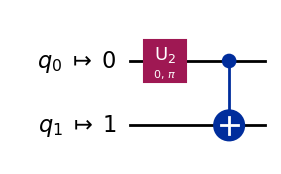

In [3]:
# from qiskit_ibm_runtime import QiskitRuntimeService
# service = QiskitRuntimeService()
# backend = service.least_busy(simulator=False, operational=True)
# Use the following code instead if you want to run on a simulator:
from qiskit_ibm_runtime.fake_provider import FakeAlmadenV2
backend = FakeAlmadenV2()

# Convert to an ISA circuit and layout-mapped observables.
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
pm = generate_preset_pass_manager(backend=backend, optimization_level=1)
isa_circuit = pm.run(qc)
isa_circuit.draw("mpl", idle_wires=False)

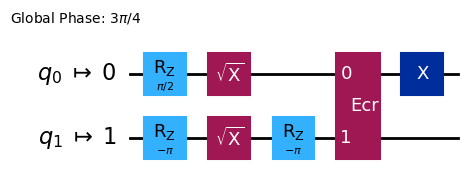

In [4]:
# from qiskit_ibm_runtime import QiskitRuntimeService
# service = QiskitRuntimeService()
# backend = service.least_busy(simulator=False, operational=True)
from qiskit_ibm_runtime.fake_provider import FakeKyiv
backend = FakeKyiv()

# Convert to an ISA circuit and layout-mapped observables.
pm = generate_preset_pass_manager(backend=backend, optimization_level=1)
isa_circuit = pm.run(qc)
isa_circuit.draw("mpl", idle_wires=False)

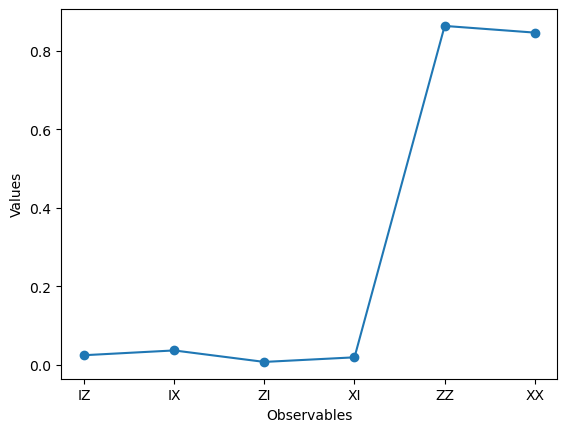

In [5]:
# Set up six different observables.
from qiskit.quantum_info import SparsePauliOp
observables_labels = ["IZ", "IX", "ZI", "XI", "ZZ", "XX"]
observables = [SparsePauliOp(label) for label in observables_labels]
mapped_observables = [
    observable.apply_layout(isa_circuit.layout) for observable in observables
]

from qiskit_ibm_runtime import EstimatorV2 as Estimator
estimator = Estimator(backend)
job = estimator.run([(isa_circuit, mapped_observables)])

# This is the result of the entire submission.  You submitted one Pub,
# so this contains one inner result (and some metadata of its own).
job_result = job.result()

# This is the result from our single pub, which had five observables,
# so contains information on all five.
pub_result = job.result()[0]# Plot the result
values = pub_result.data.evs
errors = pub_result.data.stds
 
# plotting graph
from matplotlib import pyplot as plt
plt.plot(observables_labels, values, "-o")
plt.xlabel("Observables")
plt.ylabel("Values")
plt.show()